In [1]:
import importlib
import gm_utils
importlib.reload(gm_utils)  # Forces Python to reload the updated gm_utils.py

from gm_utils import visualize_density, sample, geodesic, energy
import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm

from curves import CubicSpline
import tqdm
import numpy as np
from scipy.interpolate import interp1d
import math 

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsfonts}'

from scipy.optimize import root_scalar
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar

import torch


import torch
import torch.nn.functional as F


In [2]:
x_points = np.array([0, 1, 2, 3])
y_points = np.array([0, 2, 4, 6])
f = interp1d(x_points, y_points)

LAMBDA_MIN, LAMBDA_MAX = -30, 30 

def log_SNR(t):
    """Implementation of the linear-logSNR noise schedule"""
    return LAMBDA_MAX + (LAMBDA_MIN - LAMBDA_MAX) * t


def alpha_sigma(t):
    lambda_t = log_SNR(t)
    alpha_t = torch.sigmoid(lambda_t).sqrt()
    sigma_t = torch.sigmoid(-lambda_t).sqrt()
    return alpha_t, sigma_t


def gaussian_mixture_density(x, t):
    """Analytical implementation of the marginal log-density at time t"""
    alpha_t, sigma_t = alpha_sigma(t)
    means_t = alpha_t[:, None] * original_means[None, :]

    variances_t = sigma_t[:, None]**2 + alpha_t[:, None]**2 * original_variance
    log_probs = torch.log(weights[None, :]) - 0.5 * (torch.log(2 * torch.pi * variances_t) + (x[:, None] - means_t)**2 / variances_t)
    log_p_t = torch.logsumexp(log_probs, dim=1)
    return log_p_t


def compute_vector_field(x, t):
    """Implementation of the PF-ODE vector field"""
    alpha_t, sigma_t = alpha_sigma(t)
    f_t = 0.5 * (LAMBDA_MIN - LAMBDA_MAX) * sigma_t**2
    g2_t = (LAMBDA_MAX - LAMBDA_MIN) * sigma_t**2
    
    x.requires_grad_(True)
    log_p_t = gaussian_mixture_density(x, t)
    grad_log_p_t = torch.autograd.grad(log_p_t.sum(), x, create_graph=True)[0]
    
    dx = f_t * x - 0.5 * g2_t * grad_log_p_t
    dt = -torch.ones_like(dx)
    return dt.detach().cpu().numpy(), dx.detach().cpu().numpy()

def sample(x, n_steps, t_start=1, t_end=0):
    """PF-ODE sampling"""
    t = t_start * torch.ones_like(x)
    dt_val = (t_start - t_end) / n_steps
    all_x = [x.detach().numpy()]
    all_t = [t.detach().numpy()]
    for i in range(n_steps):
        dt, dx = compute_vector_field(x, t)
        dt, dx = torch.from_numpy(dt), torch.from_numpy(dx)
        x = x + dt * dx * dt_val
        t = t + dt * dt_val
        all_x.append(x.detach().numpy())
        all_t.append(t.detach().numpy())
    return np.array(all_t), np.array(all_x)

def eds(t, x):
    """Implementation of the denoising mean, or Expected Denoised Sample (EDS) - based on Tweedie formula using the score function - Eq61 in the paper"""
    assert t.shape == x.shape
    assert t.ndim == 1
    alpha_t, sigma_t = alpha_sigma(t)    
    x.requires_grad_(True)
    log_p_t = gaussian_mixture_density(x, t)
    grad_log_p_t = torch.autograd.grad(log_p_t.sum(), x, create_graph=True)[0]
    res = (x + sigma_t ** 2 * grad_log_p_t)
    res = res / alpha_t
    return res

def mu(theta):
    """
    Implementation of the expectation parameter - Eq 22 in the paper. Since our data distribution is 1D, the spacetime is 2D
    Parameters
    ----------
    theta: torch.Tensor
        a batch of spacetime points of shape (N, 2), where the first column is the `time` component, and the second is the `space` component
    Returns
    ----------
    mu_t : torch.Tensor
        `time` component of the expectation parameter - tensor or shape (N,)
    mu_x : torch.Tensor
        `space` component of the expectation parameter - tensor of shape (N,)
    """
    t, x = theta[:, 0], theta[:, 1]
    alpha_t, sigma_t = alpha_sigma(t)
    x.requires_grad_(True)
    f = eds(t, x)
    div = torch.autograd.grad(f.sum(), x, create_graph=True)[0] # In 1D the divergence is just the derivative
    mu_t, mu_x = sigma_t ** 2 / alpha_t * div + f ** 2, f
    return mu_t, mu_x

def eta(theta):
    """
    Implementation of the natural parameter - Eq 18 in the paper.
    Parameters
    ----------
    theta: torch.Tensor
        a batch of spacetime points of shape (N, 2), where the first column is the `time` component, and the second is the `space` component
    Returns
    ----------
    eta_t : torch.Tensor
        `time` component of the natural parameter - tensor or shape (N,)
    eta_x : torch.Tensor
        `space` component of the natural parameter - tensor of shape (N,)
    """
    t, x = theta[:, 0], theta[:, 1]
    alpha_t, sigma_t = alpha_sigma(t)
    return -0.5 * alpha_t**2/sigma_t**2, alpha_t/sigma_t**2 * x



def energy(theta):
    """
    Implementation of the energy of a discretized curve - Eq 23 in the paper.
    Parameters
    ----------
    theta: torch.Tensor
        a batch of spacetime points of shape (N, 2), where the first column is the `time` component, and the second is the `space` component
    Returns
    ----------
    energy : torch.Tensor
        Energy represented as tensor of shape (,)
    """
    mu_t, mu_x = mu(theta)
    eta_t, eta_x = eta(theta)
    energies = (mu_t[1:] - mu_t[:-1]) * (eta_t[1:] - eta_t[:-1]) + (mu_x[1:] - mu_x[:-1]) * (eta_x[1:] - eta_x[:-1])
    return energies.sum()

def geodesic(theta1, theta2, n_opt_steps, num_intermediate_points, num_nodes=20):
    """
    Implementation of approximate geodesic, parametrizes the curve as a CubicSpline and minimizes its energy w.r.t. curve's parameters using Adam optimizer
    Parameters
    ----------
    theta1: torch.Tensor
        First endpoint of the curve, represented as a point in spacetime, i.e. (2,) tensor
    theta2: torch.Tensor
        Second endpoint of the curve, represented as a point in spacetime, i.e. (2,) tensor
    n_opt_steps : int
        Number of optimization steps
    num_intermediate_points : int
        Number of points to discretize the curve into (in the paper: `N`)
    num_nodes : int
        Parameter of the CubicSpline. The higher the number of nodes, the more flexible/expressive the curve
    """
    curve = CubicSpline(begin=theta1, end=theta2, num_nodes=num_nodes)
    optimizer = torch.optim.Adam(curve.parameters(), lr=1e-1)
    t_tensor = torch.linspace(0, 1, num_intermediate_points).unsqueeze(0)
    for step_id in tqdm.tqdm(range(n_opt_steps)):
        optimizer.zero_grad()
        theta = curve(t_tensor)[0]
        loss = energy(theta)
        loss.backward()
        optimizer.step()
    return curve(t_tensor)[0].detach().numpy()



def score_function(x, t):
    """Gradient of log p_t(x) w.r.t. x (the score)."""
    x = torch.tensor([x], dtype=torch.float32, requires_grad=True)
    t = torch.tensor([t], dtype=torch.float32)
    log_p_t = gaussian_mixture_density(x, t)
    grad_log_p_t = torch.autograd.grad(log_p_t.sum(), x)[0]
    return grad_log_p_t.item()



def plot_ode_geodesics(points):

    for i, x in enumerate(points):
        pf_ode_sample = sample(x, 512, t_start=1., t_end=t_min)
        pf_ode_theta = torch.from_numpy(np.concatenate(pf_ode_sample, axis=1))
        print('Energy of pf ode trajectory:', energy(pf_ode_theta).item(), end=' ')
        theta1 = pf_ode_theta[0]
        theta2 = pf_ode_theta[-1]
        print('theta1', theta1)
        print('theta2', theta2)
        #theta1 = torch.tensor([0.00001, 2.2128]) #(theta=(t, x))
        #theta2 = torch.tensor([0.9999, 3.5])
        shortest_path12 = geodesic(theta1, theta2, n_opt_steps=1000, num_intermediate_points=128, num_nodes=2)
        print('Energy of a geodesic:', energy(torch.from_numpy(shortest_path12)).item())
        if i == 0:
            label_pf = 'PF-ODE trajectory'
            label_g = 'Spacetime Geodesic'
        else:
            label_pf = None
            label_g = None
        ax.plot(pf_ode_theta[:, 0], pf_ode_theta[:, 1], color='C3', label=label_pf)
        ax.plot(shortest_path12[:, 0], shortest_path12[:, 1], color='C3', linestyle='--', label=label_g)


 
def visualize_density(ax):
    """Estimates the marginal log-densities and visualizes it as background for the spacetime - used for both Fig1, and Fig5"""
    n_time_points = 50
    n_space_points = 200

    t_vals = torch.linspace(0, 1, n_time_points)
    x_vals = torch.linspace(-1.5, 1.5, n_space_points)
    T, X = np.meshgrid(t_vals.numpy(), x_vals.numpy())
    
    T_flat = T.flatten()
    X_flat = X.flatten()
    densities = gaussian_mixture_density(torch.from_numpy(X_flat), torch.from_numpy(T_flat)).reshape(X.shape).detach()
        
    ax.contourf(T, X, (densities).reshape(X.shape), levels=25, cmap='viridis', alpha=0.8)


In [ ]:
def sample_trajectory_points(n_trajectories=100, n_steps=512, n_points_per_trajectory=10, 
                           x_range=(-2, 2), t_start=1.0, t_end=0.1, seed=None):
    """
    Sample points along multiple PF-ODE trajectories.
    
    Parameters:
    -----------
    n_trajectories : int
        Number of different trajectories to generate
    n_steps : int  
        Number of integration steps per trajectory
    n_points_per_trajectory : int
        Number of points to sample from each trajectory
    x_range : tuple
        Range of initial x values to sample from
    t_start, t_end : float
        Start and end times for the ODE integration
    seed : int, optional
        Random seed for reproducibility
        
    Returns:
    --------
    sampled_points : torch.Tensor
        Shape (n_trajectories * n_points_per_trajectory, 2) where each row is (t, x)
    trajectory_ids : torch.Tensor
        Shape (n_trajectories * n_points_per_trajectory,) indicating which trajectory each point came from
    """
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)
    
    all_sampled_points = []
    all_trajectory_ids = []
    
    for traj_id in range(n_trajectories):
        # Sample initial point
        x_init = torch.tensor([np.random.uniform(*x_range)], dtype=torch.float32)
        
        # Generate trajectory
        t_trajectory, x_trajectory = sample(x_init, n_steps, t_start, t_end)
        
        # Combine into spacetime points (t, x)
        trajectory_points = torch.from_numpy(np.column_stack([
            t_trajectory.flatten(), 
            x_trajectory.flatten()
        ]))
        
        # Sample n_points_per_trajectory random points from this trajectory
        if len(trajectory_points) >= n_points_per_trajectory:
            indices = torch.randperm(len(trajectory_points))[:n_points_per_trajectory]
            sampled_points = trajectory_points[indices]
        else:
            # If trajectory is shorter than desired points, take all points
            sampled_points = trajectory_points
            
        all_sampled_points.append(sampled_points)
        all_trajectory_ids.append(torch.full((len(sampled_points),), traj_id))
    
    # Concatenate all sampled points
    sampled_points = torch.cat(all_sampled_points, dim=0)
    trajectory_ids = torch.cat(all_trajectory_ids, dim=0)
    
    return sampled_points, trajectory_ids


def sample_trajectory_points_uniform_time(n_trajectories=100, n_time_points=50, 
                                         x_range=(-2, 2), t_start=1.0, t_end=0.1, seed=None):
    """
    Sample points along trajectories at uniformly spaced time points.
    This gives you better control over the time distribution of sampled points.
    
    Parameters:
    -----------
    n_trajectories : int
        Number of different trajectories to generate
    n_time_points : int
        Number of time points to sample at (uniformly spaced)
    x_range : tuple
        Range of initial x values to sample from
    t_start, t_end : float
        Start and end times for the ODE integration
    seed : int, optional
        Random seed for reproducibility
        
    Returns:
    --------
    sampled_points : torch.Tensor
        Shape (n_trajectories * n_time_points, 2) where each row is (t, x)
    trajectory_ids : torch.Tensor
        Shape (n_trajectories * n_time_points,) indicating which trajectory each point came from
    """
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)
    
    # Define uniform time points to sample at
    target_times = np.linspace(t_start, t_end, n_time_points)
    
    all_sampled_points = []
    all_trajectory_ids = []
    
    for traj_id in range(n_trajectories):
        # Sample initial point
        x_init = torch.tensor([np.random.uniform(*x_range)], dtype=torch.float32)
        
        # Generate high-resolution trajectory
        t_trajectory, x_trajectory = sample(x_init, 512, t_start, t_end)
        
        # Interpolate trajectory to get x values at target times
        x_interp = np.interp(target_times, t_trajectory.flatten(), x_trajectory.flatten())
        
        # Create sampled points
        sampled_points = torch.from_numpy(np.column_stack([target_times, x_interp]))
        
        all_sampled_points.append(sampled_points)
        all_trajectory_ids.append(torch.full((len(sampled_points),), traj_id))
    
    # Concatenate all sampled points
    sampled_points = torch.cat(all_sampled_points, dim=0)
    trajectory_ids = torch.cat(all_trajectory_ids, dim=0)
    
    return sampled_points, trajectory_ids


# Example usage and visualization
def visualize_sampled_points():
    """Example of how to use the sampling functions and visualize results"""
    
    # Sample points using both methods
    points1, traj_ids1 = sample_trajectory_points(n_trajectories=20, n_points_per_trajectory=15, seed=42)
    points2, traj_ids2 = sample_trajectory_points_uniform_time(n_trajectories=10, n_time_points=20, seed=42)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot method 1: Random sampling from trajectories
    visualize_density(ax1)
    scatter1 = ax1.scatter(points1[:, 0], points1[:, 1], c=traj_ids1, s=20, alpha=0.7, cmap='tab10')
    ax1.set_title('Random Sampling from Trajectories')
    ax1.set_xlabel('Time t')
    ax1.set_ylabel('Space x')
    
    # Plot method 2: Uniform time sampling
    visualize_density(ax2)
    scatter2 = ax2.scatter(points2[:, 0], points2[:, 1], c=traj_ids2, s=20, alpha=0.7, cmap='tab10')
    ax2.set_title('Uniform Time Sampling')
    ax2.set_xlabel('Time t')
    ax2.set_ylabel('Space x')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Method 1 - Random sampling: {len(points1)} points")
    print(f"Method 2 - Uniform time: {len(points2)} points")
    
    return points1, points2

In [5]:
def metric_tensor_differentiable(theta):
    """
    theta : torch.Tensor
        Shape (N, 2), each row = (t, x_t)
    
    Returns:
    --------
    I : torch.Tensor
        Shape (N, 2, 2), metric tensor at each spacetime point
    """
    theta = theta.clone().detach().requires_grad_(True)
    N = theta.shape[0]

    eta_t, eta_x = eta(theta)
    mu_t, mu_x = mu(theta)

    eta_vec = torch.stack([eta_t, eta_x], dim=1)  
    mu_vec = torch.stack([mu_t, mu_x], dim=1)     #

    I_batch = torch.zeros((N, 2, 2), dtype=theta.dtype, device=theta.device)

    for n in range(N):
        # Compute Jacobians J_eta and J_mu
        J_eta = torch.zeros((2, 2), dtype=theta.dtype, device=theta.device)
        J_mu = torch.zeros((2, 2), dtype=theta.dtype, device=theta.device)

        for k in range(2):
            grad_eta_k = torch.autograd.grad(
                eta_vec[n, k], theta, retain_graph=True, create_graph=True
            )[0][n]  # gradient w.r.t. θ for η_k
            grad_mu_k = torch.autograd.grad(
                mu_vec[n, k], theta, retain_graph=True, create_graph=True
            )[0][n]  # gradient w.r.t. θ for μ_k

            J_eta[k, :] = grad_eta_k
            J_mu[k, :] = grad_mu_k

        #print('Jacobian eta:',J_eta,'Jacobian J_mu:', J_mu)
        I_batch[n] = J_eta.T @ J_mu

    return I_batch, theta 

Energy of pf ode trajectory: 0.9801619648933411 theta1 tensor([1., 1.])
theta2 tensor([0.1000, 0.3128])


100%|██████████| 1000/1000 [00:03<00:00, 315.33it/s]


Energy of a geodesic: 95.51589965820312
Energy of pf ode trajectory: 1.0629043579101562 theta1 tensor([1.0000, 0.2000])
theta2 tensor([0.1000, 0.0626])


100%|██████████| 1000/1000 [00:03<00:00, 301.65it/s]


Energy of a geodesic: 15.281102180480957
Energy of pf ode trajectory: 0.9801619648933411 theta1 tensor([ 1., -1.])
theta2 tensor([ 0.1000, -0.3128])


100%|██████████| 1000/1000 [00:05<00:00, 192.12it/s]


Energy of a geodesic: 95.51589965820312


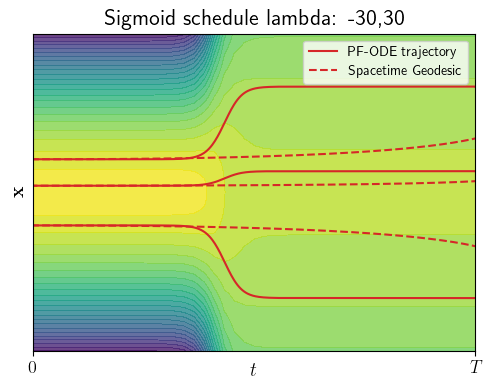

metric dif (tensor([[[40.4660, -2.1570],
         [-2.1570,  0.1818]]], grad_fn=<CopySlices>), tensor([[0.5000, 0.3000]], requires_grad=True))


In [ ]:
original_means = torch.tensor([0], dtype=torch.float32) #0,0,0   #-1,1,0
original_variance = torch.tensor(0.1, dtype=torch.float32) #0.4
weights = torch.tensor([1], dtype=torch.float32)


fig, ax = plt.subplots(figsize=(5, 4))
t_min = 0.1
visualize_density(ax)

plot_ode_geodesics(torch.tensor([[1.], [0.2], [-1]]))

ax.legend()
ax.set_xlim((t_min, 1))
ax.set_xticks([t_min, 1], [r'$0$', r'$T$'], fontsize=13)
ax.set_yticks([])
ax.set_xlabel(r'$t$', fontsize=14, labelpad=-10)
ax.set_ylabel(r'$\mathbf{x}$', fontsize=14)
ax.set_title('Sigmoid schedule lambda: -30,30', fontsize=16)
plt.tight_layout()
plt.show()

print('metric dif', metric_tensor_differentiable(torch.tensor([[0.5, 0.3]])))


In [ ]:
# Test the trajectory sampling functions
print("Testing trajectory point sampling...")

# Generate sampled points
sampled_points, trajectory_ids = sample_trajectory_points(
    n_trajectories=15, 
    n_points_per_trajectory=20, 
    x_range=(-1.5, 1.5),
    seed=42
)

uniform_points, uniform_ids = sample_trajectory_points_uniform_time(
    n_trajectories=8,
    n_time_points=25,
    x_range=(-1.5, 1.5),
    seed=42
)

print(f"Random sampling: {len(sampled_points)} points from {len(torch.unique(trajectory_ids))} trajectories")
print(f"Uniform time sampling: {len(uniform_points)} points from {len(torch.unique(uniform_ids))} trajectories")

# Visualize the results
visualize_sampled_points()

In [8]:
def compute_sectional_curvature(theta):
    """
    theta : torch.Tensor
        Shape (N, 2), coordinates (t, x_t)
    """

    g, theta_diff = metric_tensor_differentiable(theta)
    N = g.shape[0]
    g_inv = torch.inverse(g)  

    christoffel = torch.zeros((N, 2, 2, 2), dtype=theta.dtype, device=theta.device)
    g_derivs = torch.zeros((N, 2, 2, 2), dtype=theta.dtype, device=theta.device)

    #Compute all the derivatives of the metric
    for n in range(N):
        for i in range(2):
            for j in range(2):
                
                grad_outputs = torch.zeros_like(g[n, i, j])
                grad_outputs = grad_outputs + 1.0

                grad_g_ij = torch.autograd.grad(
                    g[n, i, j], theta_diff,
                    grad_outputs=grad_outputs,
                    retain_graph=True,
                    create_graph=True,
                    only_inputs=True
                )[0][n]  

                g_derivs[n, i, j, :] = grad_g_ij

    # Compute Christoffel symbols: Γ^k_ij 
    for n in range(N):
        for k in range(2):
            for i in range(2):
                for j in range(2):
                    sum_term = 0.0
                    for l in range(2):
                        bracket_term = (g_derivs[n, i, l, j] +    
                                       g_derivs[n, j, l, i] -     
                                       g_derivs[n, i, j, l])      
                        sum_term += g_inv[n, k, l] * bracket_term

                    christoffel[n, k, i, j] = 0.5 * sum_term

    # Compute Riemann tensor component R^1_212

    R_1212 = torch.zeros(N, dtype=theta.dtype, device=theta.device)

    for n in range(N):
        # i, j, k, l = 0, 1, 0, 1  
        i, j, k, l = 0, 1, 0, 1

        if christoffel[n, i, j, l].requires_grad:
            dchrist_jl_k = torch.autograd.grad(
                christoffel[n, i, j, l], theta_diff,
                grad_outputs=torch.ones_like(christoffel[n, i, j, l]),
                retain_graph=True,
                create_graph=False,
                only_inputs=True
            )[0][n, k]
        else:
            dchrist_jl_k = torch.tensor(0.0, dtype=theta.dtype, device=theta.device)

        if christoffel[n, i, j, k].requires_grad:
            dchrist_jk_l = torch.autograd.grad(
                christoffel[n, i, j, k], theta_diff,
                grad_outputs=torch.ones_like(christoffel[n, i, j, k]),
                retain_graph=True,
                create_graph=False,
                only_inputs=True
            )[0][n, l]
        else:
            dchrist_jk_l = torch.tensor(0.0, dtype=theta.dtype, device=theta.device)

        
        quad1 = sum(christoffel[n, i, m, k] * christoffel[n, m, j, l] for m in range(2))
        quad2 = sum(christoffel[n, i, m, l] * christoffel[n, m, j, k] for m in range(2))

        R_1212[n] = dchrist_jl_k - dchrist_jk_l + quad1 - quad2

   
    # Compute the missing upper-index component R^1_101
    R_2212 = torch.zeros(N, dtype=theta.dtype, device=theta.device) 

    for n in range(N):
        i2, j2, k2, l2 = 1, 1, 0, 1 
        if christoffel[n, i2, j2, l2].requires_grad:
            dchrist_jl_k_2 = torch.autograd.grad(
                christoffel[n, i2, j2, l2], theta_diff,
                grad_outputs=torch.ones_like(christoffel[n, i2, j2, l2]),
                retain_graph=True,
                create_graph=False,
                only_inputs=True
            )[0][n, k2]
        else:
            dchrist_jl_k_2 = torch.tensor(0.0, dtype=theta.dtype, device=theta.device)

        if christoffel[n, i2, j2, k2].requires_grad:
            dchrist_jk_l_2 = torch.autograd.grad(
                christoffel[n, i2, j2, k2], theta_diff,
                grad_outputs=torch.ones_like(christoffel[n, i2, j2, k2]),
                retain_graph=True,
                create_graph=False,
                only_inputs=True
            )[0][n, l2]
        else:
            dchrist_jk_l_2 = torch.tensor(0.0, dtype=theta.dtype, device=theta.device)

        quad1_2 = sum(christoffel[n, i2, m, k2] * christoffel[n, m, j2, l2] for m in range(2))
        quad2_2 = sum(christoffel[n, i2, m, l2] * christoffel[n, m, j2, k2] for m in range(2))

        R_2212[n] = dchrist_jl_k_2 - dchrist_jk_l_2 + quad1_2 - quad2_2

    # Lower the indices by multiplying with the metric:
    #print('R1212', R_1212)
    #print('R1012', R_up_i1)
    R_lowered_1212 = g[:, 0, 0] * R_1212 + g[:, 0, 1] * R_2212
    #print('first metric:', g[:, 0, 0])
    #print(R_lowered_1212, torch.det(g)  )

    # Sectional curvature K = R_{1212} / det(g) for 2D manifold (use lowered component)
    
    det_g = torch.det(g)  # (N,)
    K = R_lowered_1212 / det_g

    return K


print('sectional 3', compute_sectional_curvature(torch.tensor([[0.2, -0.4]])))



sectional 3 tensor([-0.4970], grad_fn=<DivBackward0>)
